# Introduction to image segmentation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Create a simple dataset
class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128):
        self.size = size
        self.image_size = image_size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Create a random input image
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 4)

        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target = (distance < radius).float().unsqueeze(0)

        # Add noise to the target to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.8
        input_image = target + noise

        return input_image, target

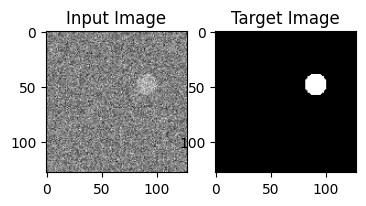

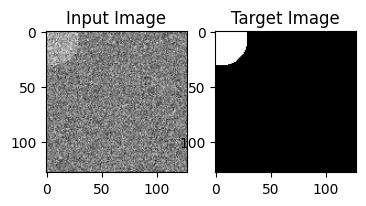

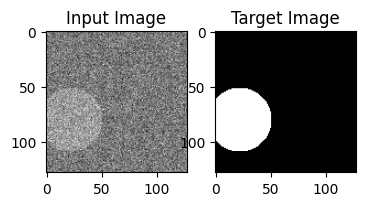

In [13]:
import matplotlib.pyplot as plt
# Create an instance of the dataset
dataset = SimpleDataset(size=1, image_size=128)

# Get a sample from the dataset
for i in range(3):
    input_image, target = dataset[i]
    # Visualize the input image
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0], cmap='gray')
    plt.title('Input Image')
    # plt.show()
    # Visualize the target image
    plt.subplot(1, 2, 2)
    plt.imshow(target[0], cmap='gray')
    plt.title('Target Image')
    plt.show()
    # break


# Simple image to image

[Autoencoder](https://blog.paperspace.com/convolutional-autoencoder/)

In [14]:
# Define a simple model with ConvTranspose2d
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layer to reduce spatial dimensions
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)
        # ConvTranspose2d layer to increase spatial dimensions
        self.conv_transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Downsample
        x = self.conv(x)
        # Upsample
        x = self.conv_transpose(x)
        return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = SimpleDataset()
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [16]:
# Initialize the model, loss function, and optimizer
model = SimpleAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_loss = train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

Epoch [1/150], Average Loss: 0.7040
Epoch [2/150], Average Loss: 0.6881
Epoch [3/150], Average Loss: 0.6891
Epoch [4/150], Average Loss: 0.6689
Epoch [5/150], Average Loss: 0.6772
Epoch [6/150], Average Loss: 0.6523
Epoch [7/150], Average Loss: 0.6637
Epoch [8/150], Average Loss: 0.6490
Epoch [9/150], Average Loss: 0.6347
Epoch [10/150], Average Loss: 0.6218
Epoch [11/150], Average Loss: 0.6266
Epoch [12/150], Average Loss: 0.6195
Epoch [13/150], Average Loss: 0.6196
Epoch [14/150], Average Loss: 0.6095
Epoch [15/150], Average Loss: 0.6055
Epoch [16/150], Average Loss: 0.5909
Epoch [17/150], Average Loss: 0.5857
Epoch [18/150], Average Loss: 0.5855
Epoch [19/150], Average Loss: 0.5783
Epoch [20/150], Average Loss: 0.5747
Epoch [21/150], Average Loss: 0.5671
Epoch [22/150], Average Loss: 0.5697
Epoch [23/150], Average Loss: 0.5645
Epoch [24/150], Average Loss: 0.5621
Epoch [25/150], Average Loss: 0.5564
Epoch [26/150], Average Loss: 0.5535
Epoch [27/150], Average Loss: 0.5475
Epoch [28/

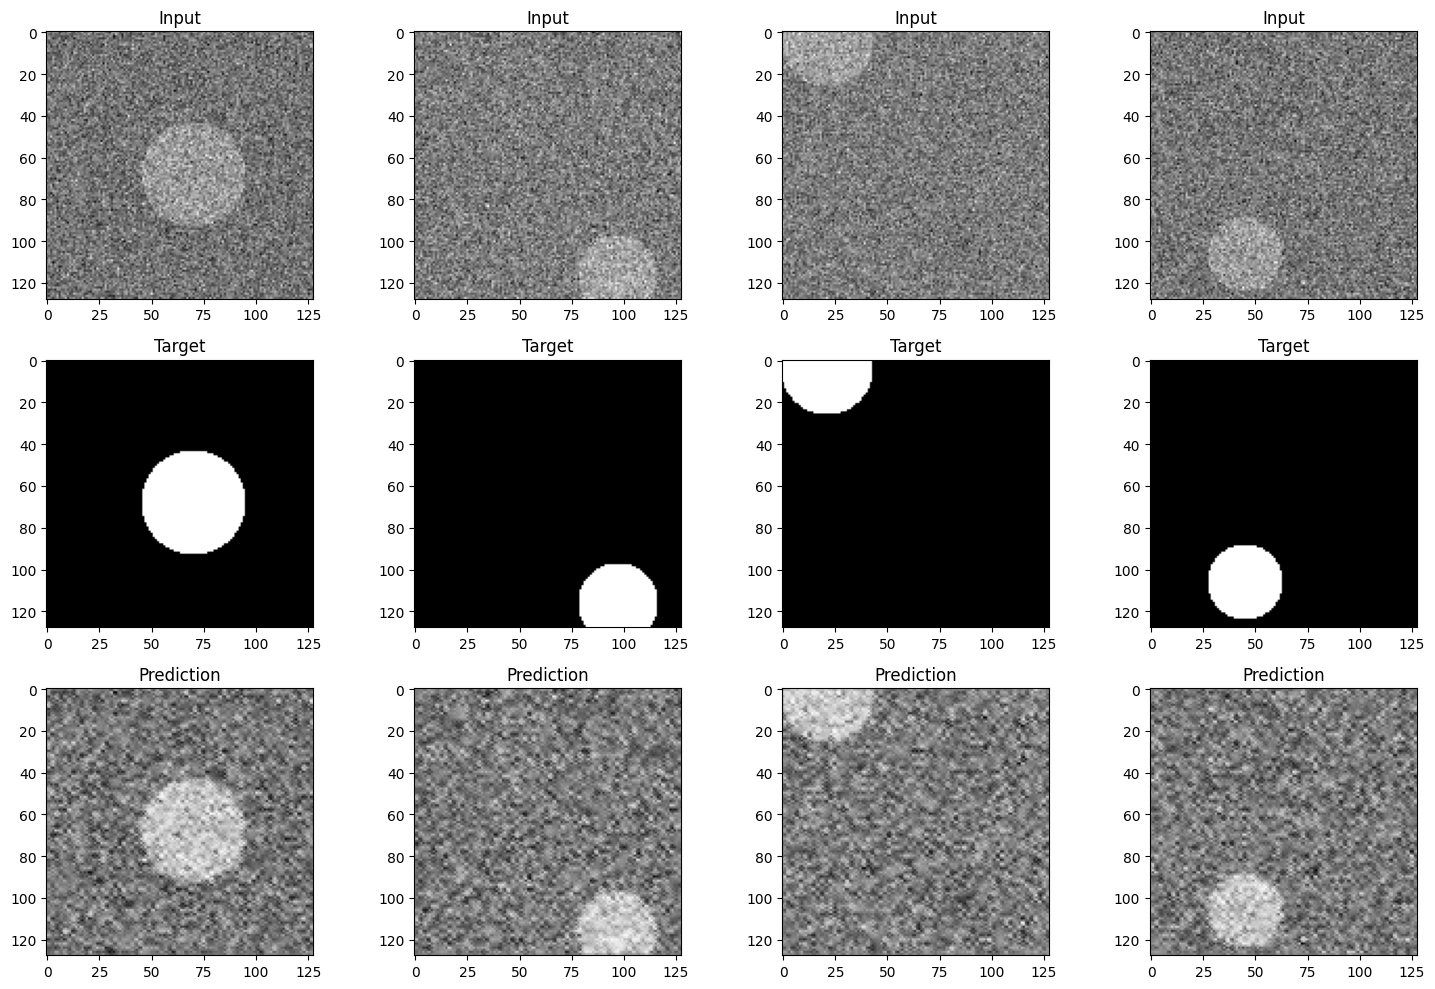

In [18]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

In [20]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
# Initialize the model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_loss = train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

Epoch [1/50], Average Loss: 0.8413
Epoch [2/50], Average Loss: 0.7618
Epoch [3/50], Average Loss: 0.7237
Epoch [4/50], Average Loss: 0.7132
Epoch [5/50], Average Loss: 0.6894
Epoch [6/50], Average Loss: 0.6712
Epoch [7/50], Average Loss: 0.6610
Epoch [8/50], Average Loss: 0.6563
Epoch [9/50], Average Loss: 0.6548
Epoch [10/50], Average Loss: 0.6533
Epoch [11/50], Average Loss: 0.6521
Epoch [12/50], Average Loss: 0.6542
Epoch [13/50], Average Loss: 0.6521
Epoch [14/50], Average Loss: 0.6496
Epoch [15/50], Average Loss: 0.6488
Epoch [16/50], Average Loss: 0.6475
Epoch [17/50], Average Loss: 0.6481
Epoch [18/50], Average Loss: 0.6482
Epoch [19/50], Average Loss: 0.6466
Epoch [20/50], Average Loss: 0.6468
Epoch [21/50], Average Loss: 0.6450
Epoch [22/50], Average Loss: 0.6439
Epoch [23/50], Average Loss: 0.6447
Epoch [24/50], Average Loss: 0.6451
Epoch [25/50], Average Loss: 0.6435
Epoch [26/50], Average Loss: 0.6427
Epoch [27/50], Average Loss: 0.6431
Epoch [28/50], Average Loss: 0.6427
E

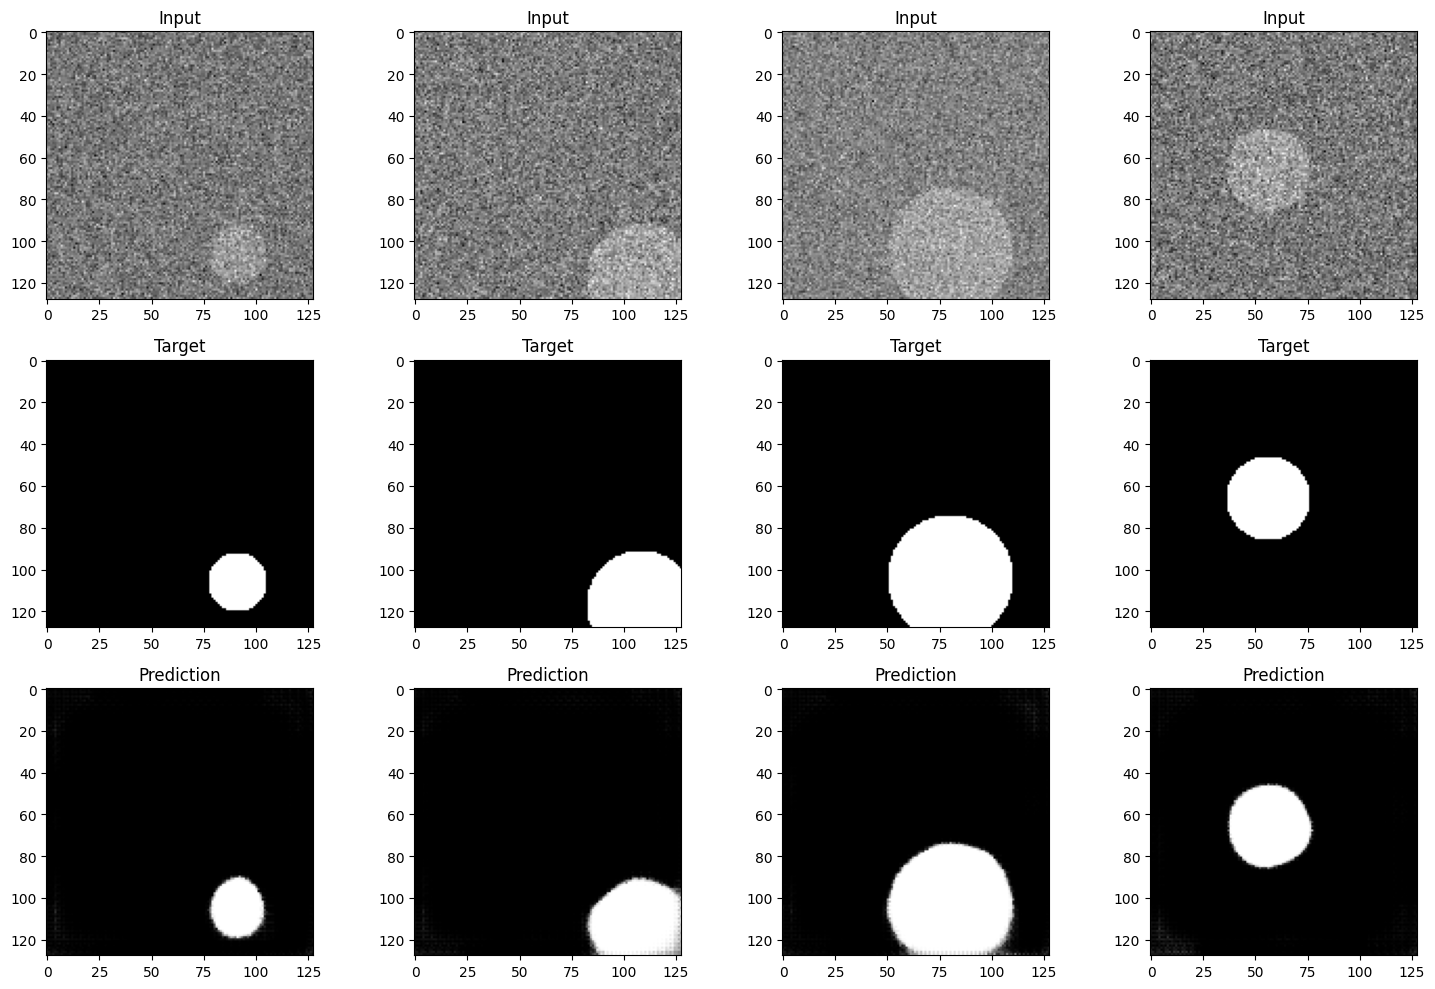

In [22]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

# U-Net architecture
[Pytorch-UNet](https://github.com/milesial/Pytorch-UNet)

In [23]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [24]:
# Set up the model, loss function, and optimizer

model = UNet(in_channels=1, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Create the dataset and data loader
dataset = SimpleDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Epoch 1/50, Loss: 1.0546
Epoch 2/50, Loss: 0.4703
Epoch 3/50, Loss: 0.3887
Epoch 4/50, Loss: 0.2508
Epoch 5/50, Loss: 0.1739
Epoch 6/50, Loss: 0.1375
Epoch 7/50, Loss: 0.1067
Epoch 8/50, Loss: 0.0951
Epoch 9/50, Loss: 0.0768
Epoch 10/50, Loss: 0.0609
Epoch 11/50, Loss: 0.0663
Epoch 12/50, Loss: 0.0323
Epoch 13/50, Loss: 0.0090
Epoch 14/50, Loss: 0.0097
Epoch 15/50, Loss: 0.0097
Epoch 16/50, Loss: 0.0086
Epoch 17/50, Loss: 0.0075
Epoch 18/50, Loss: 0.0066
Epoch 19/50, Loss: 0.0063
Epoch 20/50, Loss: 0.0065
Epoch 21/50, Loss: 0.0068
Epoch 22/50, Loss: 0.0067
Epoch 23/50, Loss: 0.0064
Epoch 24/50, Loss: 0.0059
Epoch 25/50, Loss: 0.0057
Epoch 26/50, Loss: 0.0057
Epoch 27/50, Loss: 0.0057
Epoch 28/50, Loss: 0.0064
Epoch 29/50, Loss: 0.0055
Epoch 30/50, Loss: 0.0055
Epoch 31/50, Loss: 0.0056
Epoch 32/50, Loss: 0.0056
Epoch 33/50, Loss: 0.0056
Epoch 34/50, Loss: 0.0057
Epoch 35/50, Loss: 0.0057
Epoch 36/50, Loss: 0.0053
Epoch 37/50, Loss: 0.0049
Epoch 38/50, Loss: 0.0051
Epoch 39/50, Loss: 0.

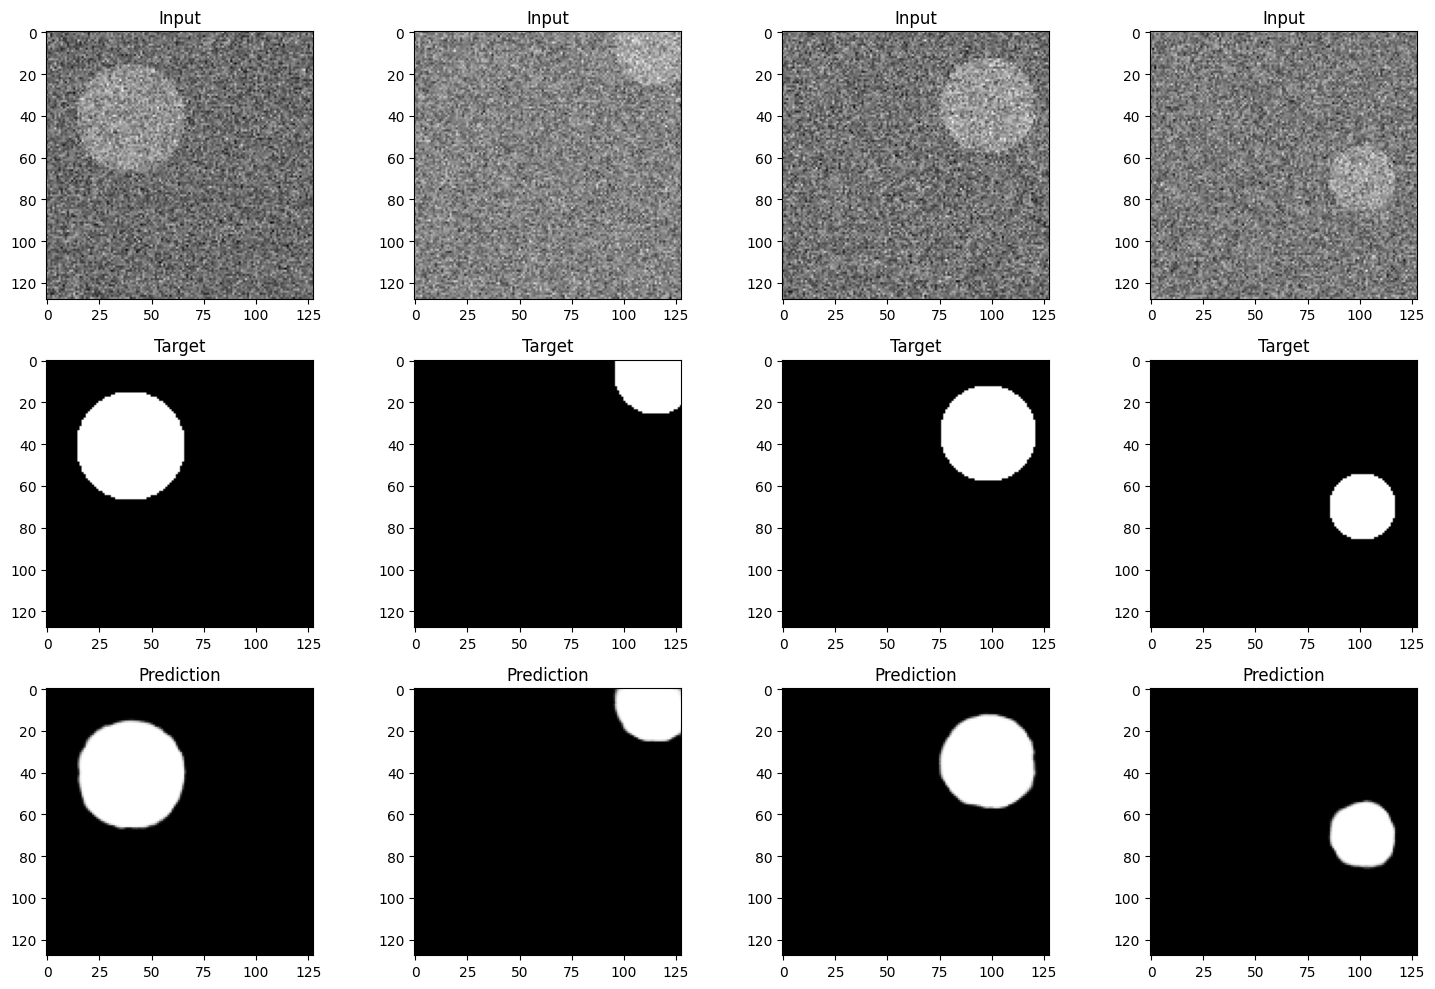

In [25]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

In [26]:
# !pip install torchviz

In [27]:
# # Visualize the model architecture
# from torchviz import make_dot

# x = torch.randn(1, 1, 128, 128).to(device)
# y = model(x)
# dot = make_dot(y.mean(), params=dict(model.named_parameters()))
# dot.render("unet_architecture", format="png")

'unet_architecture.png'

# Multiple object

In [28]:
class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128):
        self.size = size
        self.image_size = image_size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Create a blank canvas for target
        target = torch.zeros(2, self.image_size, self.image_size)

        # Generate circle
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 6)
        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target[0] = (distance < radius).float()

        # Generate rectangle
        rect_x = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_y = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_w = np.random.randint(self.image_size // 8, self.image_size // 4)
        rect_h = np.random.randint(self.image_size // 8, self.image_size // 4)
        target[1, rect_x:rect_x+rect_w, rect_y:rect_y+rect_h] = 1

        # Combine circle and rectangle
        combined_target = (target.sum(dim=0) > 0).float().unsqueeze(0)

        # Add noise to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.5
        input_image = combined_target + noise

        return input_image, target

In [29]:
# Define the U-Net architecture (unchanged)
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [30]:
# Set up the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Create the dataset and data loader
dataset = SimpleDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

Epoch 1/50, Loss: 0.6682
Epoch 2/50, Loss: 0.4379
Epoch 3/50, Loss: 0.2416
Epoch 4/50, Loss: 0.1390
Epoch 5/50, Loss: 0.0987
Epoch 6/50, Loss: 0.0799
Epoch 7/50, Loss: 0.0694
Epoch 8/50, Loss: 0.0656
Epoch 9/50, Loss: 0.0583
Epoch 10/50, Loss: 0.0558
Epoch 11/50, Loss: 0.0524
Epoch 12/50, Loss: 0.0531
Epoch 13/50, Loss: 0.0494
Epoch 14/50, Loss: 0.0525
Epoch 15/50, Loss: 0.0484
Epoch 16/50, Loss: 0.0737
Epoch 17/50, Loss: 0.0570
Epoch 18/50, Loss: 0.0519
Epoch 19/50, Loss: 0.0452
Epoch 20/50, Loss: 0.0418
Epoch 21/50, Loss: 0.0451
Epoch 22/50, Loss: 0.0388
Epoch 23/50, Loss: 0.0331
Epoch 24/50, Loss: 0.0229
Epoch 25/50, Loss: 0.0174
Epoch 26/50, Loss: 0.0134
Epoch 27/50, Loss: 0.0216
Epoch 28/50, Loss: 0.0144
Epoch 29/50, Loss: 0.0139
Epoch 30/50, Loss: 0.0137
Epoch 31/50, Loss: 0.0107
Epoch 32/50, Loss: 0.0092
Epoch 33/50, Loss: 0.0068
Epoch 34/50, Loss: 0.0106
Epoch 35/50, Loss: 0.0084
Epoch 36/50, Loss: 0.0108
Epoch 37/50, Loss: 0.0080
Epoch 38/50, Loss: 0.0072
Epoch 39/50, Loss: 0.

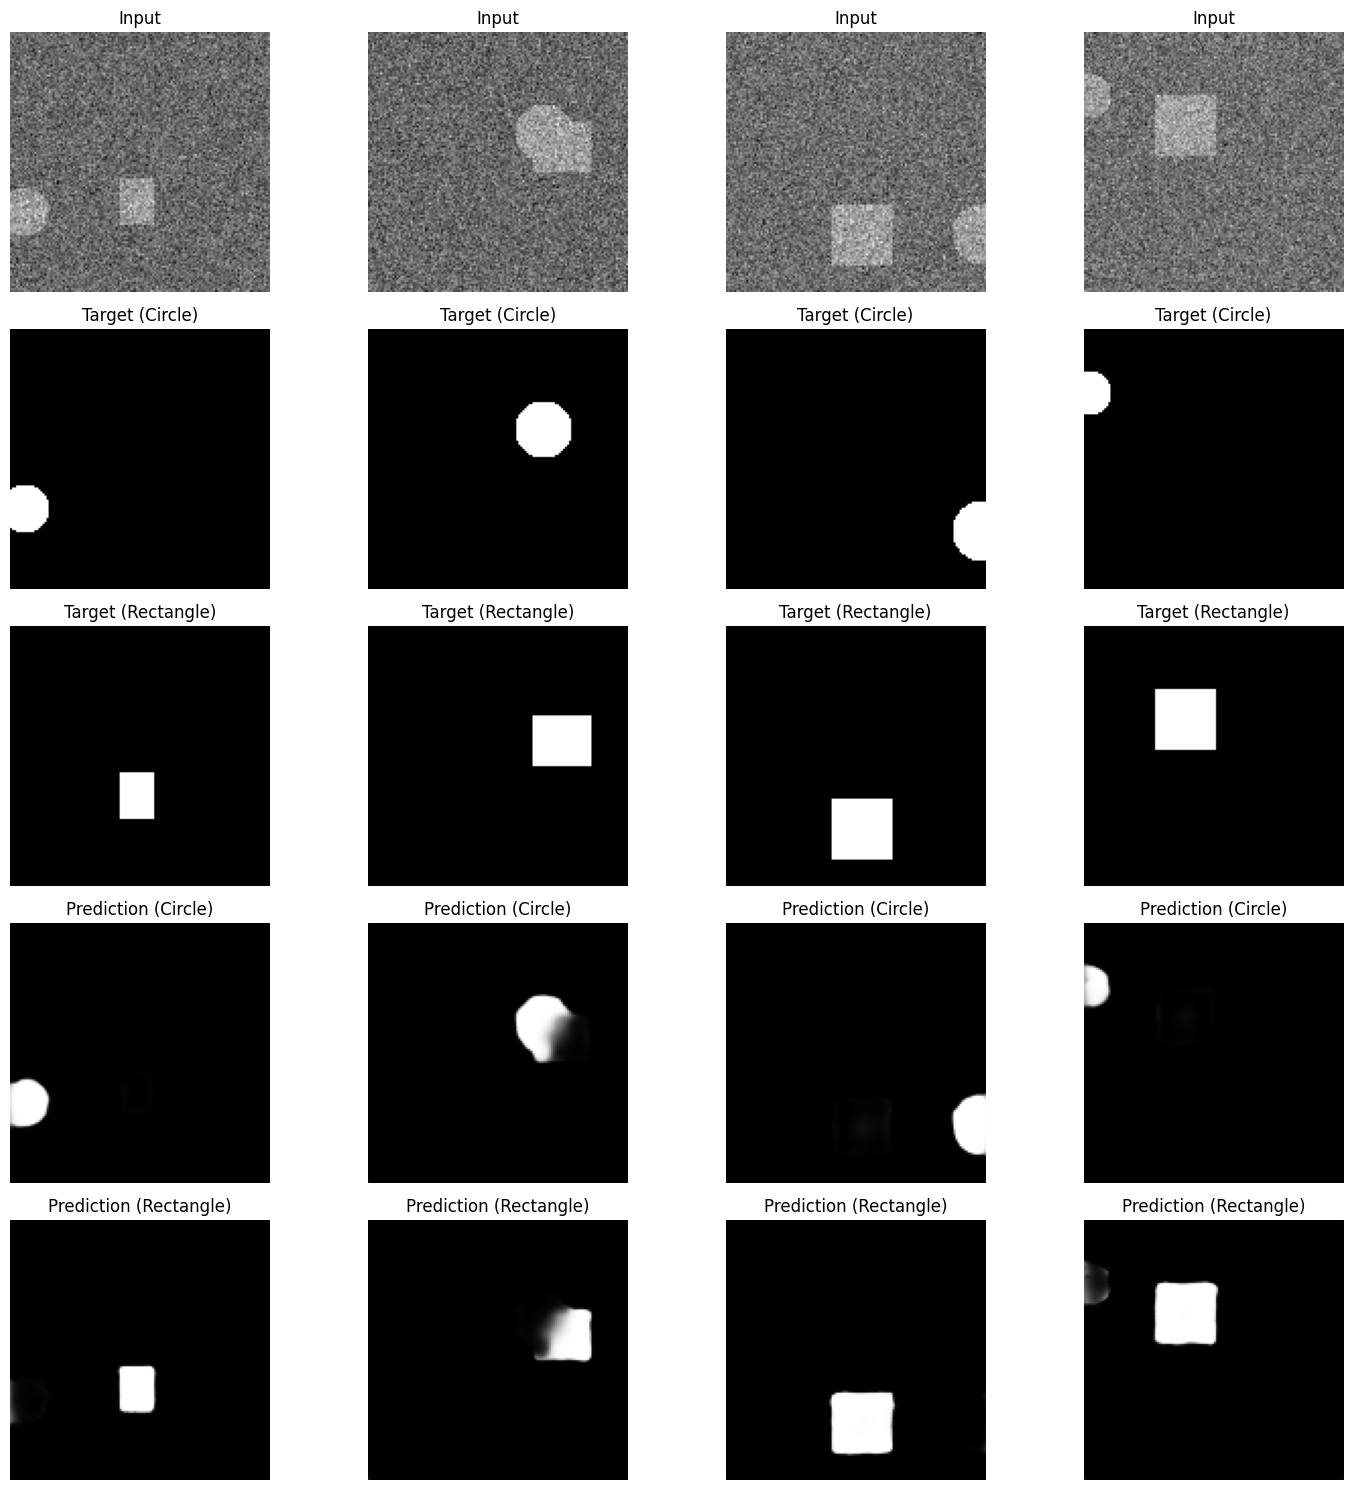

In [31]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(5, 4, figsize=(15, 15))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[0, i].axis('off')

        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target (Circle)')
        axes[1, i].axis('off')

        axes[2, i].imshow(targets[i, 1].cpu(), cmap='gray')
        axes[2, i].set_title('Target (Rectangle)')
        axes[2, i].axis('off')

        axes[3, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[3, i].set_title('Prediction (Circle)')
        axes[3, i].axis('off')

        axes[4, i].imshow(outputs[i, 1].cpu(), cmap='gray')
        axes[4, i].set_title('Prediction (Rectangle)')
        axes[4, i].axis('off')

    plt.tight_layout()
    plt.show()

# Hand on

Revise the code to be able to segment 4 objects per image using U-Net.

In [108]:
# from PIL import Image
import os
from PIL import Image
from skimage import draw

# Define the SimpleDataset with 4 objects

class SimpleDataset(Dataset):
    def __init__(self, size=250, image_size=128, save_path=None):
        self.size = size
        self.image_size = image_size
        self.save_path = save_path  # Path for saving input and target data

        # Create directories for saving data
        if save_path:
            os.makedirs(os.path.join(save_path, "input_images"), exist_ok=True)
            os.makedirs(os.path.join(save_path, "targets"), exist_ok=True)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        target = torch.zeros(4, self.image_size, self.image_size)

        # Generate circle
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 6)
        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target[0] = (distance < radius).float()

        # Generate rectangle
        rect_x = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_y = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_w = np.random.randint(self.image_size // 8, self.image_size // 4)
        rect_h = np.random.randint(self.image_size // 8, self.image_size // 4)
        target[1, rect_x:rect_x+rect_w, rect_y:rect_y+rect_h] = 1

        # Generate triangle
        triangle_x = np.random.randint(0, self.image_size - self.image_size // 4)
        triangle_y = np.random.randint(0, self.image_size - self.image_size // 4)
        triangle_size = np.random.randint(self.image_size // 8, self.image_size // 4)

        triangle_vertices = [
            (triangle_x, triangle_y),
            (triangle_x + triangle_size, triangle_y),
            (triangle_x + triangle_size // 2, triangle_y + triangle_size),
        ]
        triangle_mask = torch.zeros(self.image_size, self.image_size)

        for i in range(self.image_size):
            for j in range(self.image_size):
                p = (j, i)
                b1 = (p[0] - triangle_vertices[1][0]) * (triangle_vertices[0][1] - triangle_vertices[1][1]) - (triangle_vertices[0][0] - triangle_vertices[1][0]) * (p[1] - triangle_vertices[1][1])
                b2 = (p[0] - triangle_vertices[2][0]) * (triangle_vertices[1][1] - triangle_vertices[2][1]) - (triangle_vertices[1][0] - triangle_vertices[2][0]) * (p[1] - triangle_vertices[2][1])
                b3 = (p[0] - triangle_vertices[0][0]) * (triangle_vertices[2][1] - triangle_vertices[0][1]) - (triangle_vertices[2][0] - triangle_vertices[0][0]) * (p[1] - triangle_vertices[0][1])
                if (b1 <= 0 and b2 <= 0 and b3 <= 0) or (b1 >= 0 and b2 >= 0 and b3 >= 0):
                    triangle_mask[i, j] = 1
        target[2] = triangle_mask

        # Generate heart shape
        heart_center_x = self.image_size // 2
        heart_center_y = self.image_size // 2
        heart_scale = self.image_size // 8

        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        x = x - heart_center_x
        y = y - heart_center_y

        heart_eq = ((x / heart_scale)**2 + (y / heart_scale)**2 - 1)**3 - (x / heart_scale)**2 * (y / heart_scale)**3
        target_heart = (heart_eq <= 0).float()

        target[3] = target_heart

        # Combine circle and rectangle
        combined_target = (target.sum(dim=0) > 0).float().unsqueeze(0)

        # Add noise to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.3
        input_image = combined_target + noise

        # Save the data if save_path is provided
        if self.save_path:
            self.save_data(input_image, target, idx)

        return input_image, target

    # Opptional for saving image and target
    def save_data(self, input_image, target, idx):
        input_image_path = os.path.join(self.save_path, "input_images", f"input_{idx:04d}.png")
        target_path = os.path.join(self.save_path, "targets", f"target_{idx:04d}.npy")

        # Save input image as .png
        input_image_np = (input_image[0].cpu().numpy() * 255).astype(np.uint8)
        Image.fromarray(input_image_np).save(input_image_path)

        # Save target as .npy
        target_np = target.cpu().numpy()
        np.save(target_path, target_np)

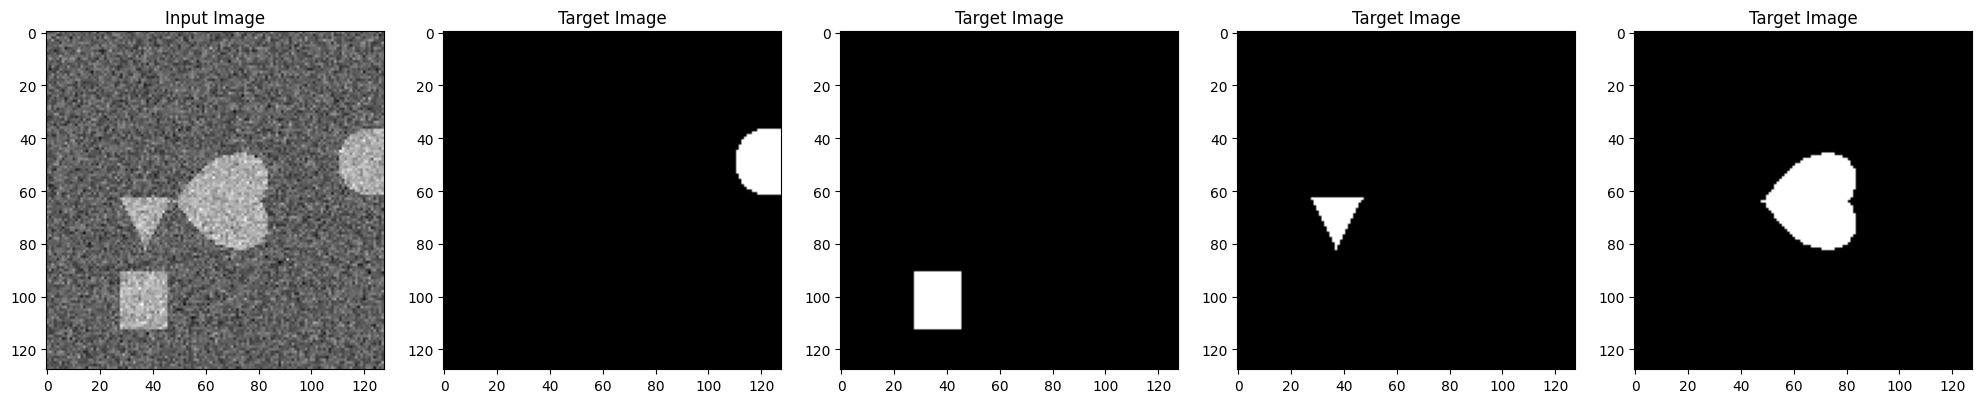

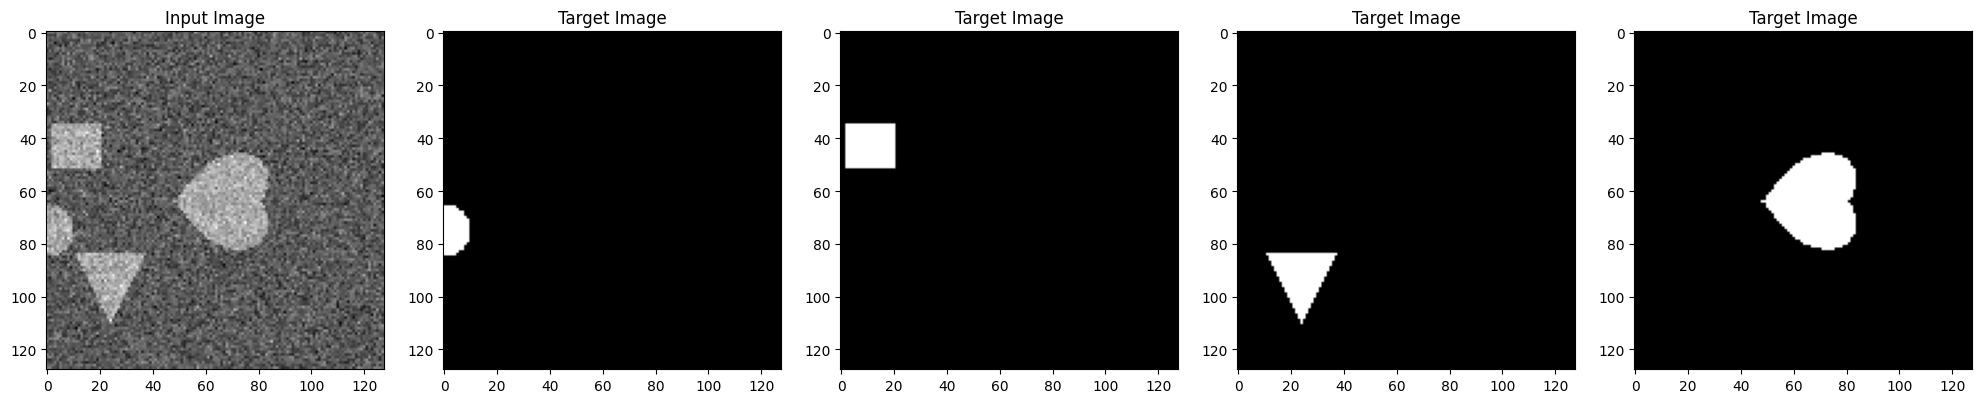

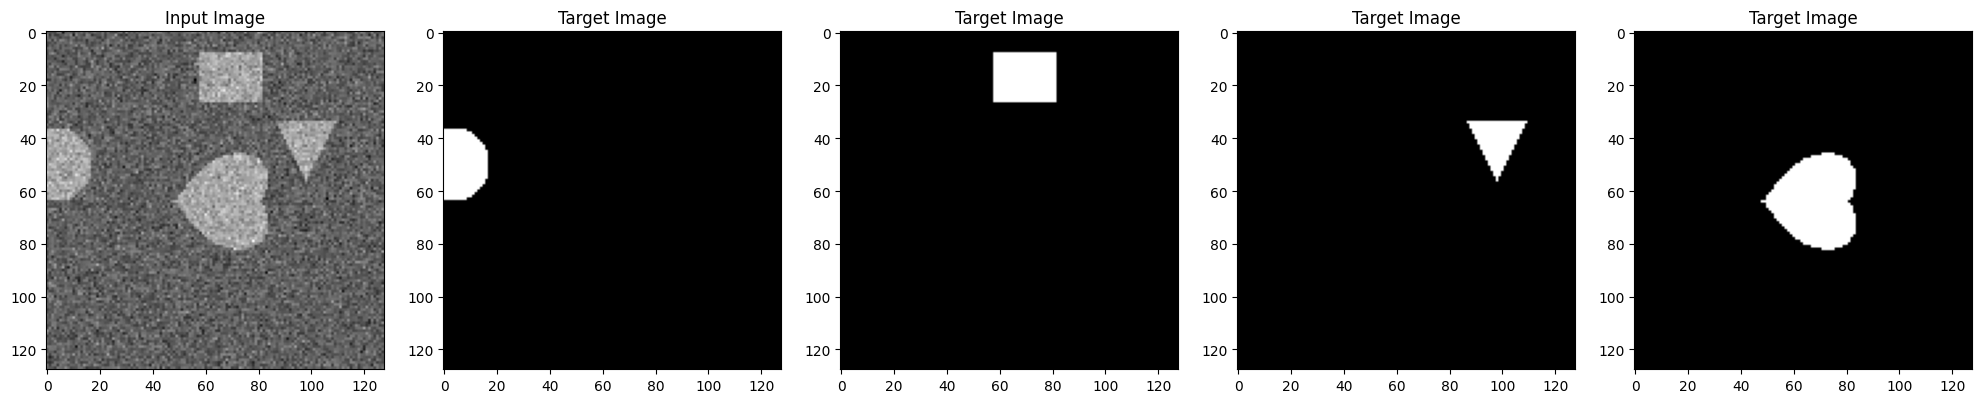

In [107]:
dataset = SimpleDataset(size=1, image_size=128)

for i in range(3):
    input_image, target = dataset[i]

    plt.figure(figsize=(20, 5))  # Adjust the figure size to fit all images in a row
    plt.subplot(1, 5, 1)
    plt.imshow(input_image[0], cmap='gray')
    plt.title('Input Image')

    plt.subplot(1, 5, 2)
    plt.imshow(target[0], cmap='gray')
    plt.title('Target Image')

    plt.subplot(1, 5, 3)
    plt.imshow(target[1], cmap='gray')
    plt.title('Target Image')

    plt.subplot(1, 5, 4)
    plt.imshow(target[2], cmap='gray')
    plt.title('Target Image')

    plt.subplot(1, 5, 5)
    plt.imshow(target[3], cmap='gray')
    plt.title('Target Image')

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()


In [69]:
# Define the U-Net architecture, code here
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [110]:
dataset = SimpleDataset()
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [111]:
# Set up the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=4).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Create the dataset and data loader
dataset = SimpleDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

Epoch 1/50, Loss: 0.6377
Epoch 2/50, Loss: 0.2460
Epoch 3/50, Loss: 0.0968
Epoch 4/50, Loss: 0.0872
Epoch 5/50, Loss: 0.0814
Epoch 6/50, Loss: 0.0781
Epoch 7/50, Loss: 0.0808
Epoch 8/50, Loss: 0.0812
Epoch 9/50, Loss: 0.0799
Epoch 10/50, Loss: 0.0774
Epoch 11/50, Loss: 0.0736
Epoch 12/50, Loss: 0.0707
Epoch 13/50, Loss: 0.0643
Epoch 14/50, Loss: 0.0726
Epoch 15/50, Loss: 0.0592
Epoch 16/50, Loss: 0.0533
Epoch 17/50, Loss: 0.0524
Epoch 18/50, Loss: 0.0409
Epoch 19/50, Loss: 0.0345
Epoch 20/50, Loss: 0.0265
Epoch 21/50, Loss: 0.0221
Epoch 22/50, Loss: 0.0198
Epoch 23/50, Loss: 0.0200
Epoch 24/50, Loss: 0.0177
Epoch 25/50, Loss: 0.0170
Epoch 26/50, Loss: 0.0177
Epoch 27/50, Loss: 0.0147
Epoch 28/50, Loss: 0.0127
Epoch 29/50, Loss: 0.0135
Epoch 30/50, Loss: 0.0123
Epoch 31/50, Loss: 0.0132
Epoch 32/50, Loss: 0.0123
Epoch 33/50, Loss: 0.0126
Epoch 34/50, Loss: 0.0104
Epoch 35/50, Loss: 0.0107
Epoch 36/50, Loss: 0.0111
Epoch 37/50, Loss: 0.0109
Epoch 38/50, Loss: 0.0118
Epoch 39/50, Loss: 0.

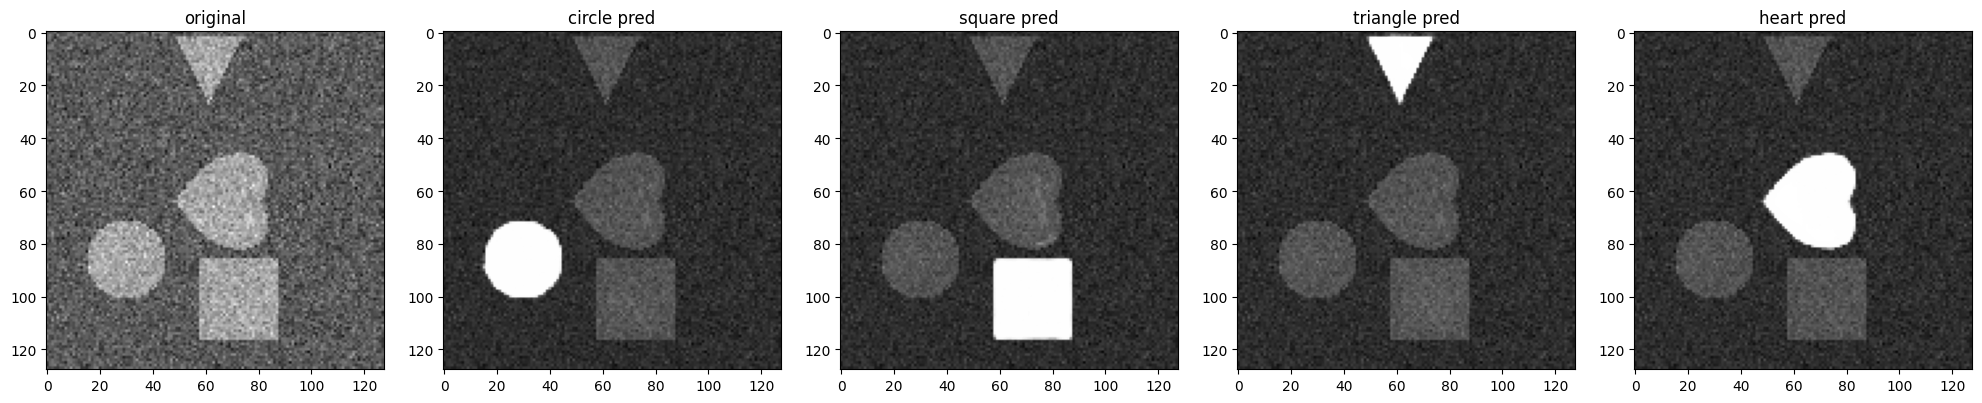

In [174]:
model.eval()
with torch.no_grad():
    input, targets = dataset[0]
    input, targets = input.to(device), targets.to(device)
    input_model = input.unsqueeze(0)
    outputs = model(input_model)
    outputs = torch.sigmoid(outputs)

    original_image = input.cpu()[0]
    circle = outputs.cpu()[0][0]
    square = outputs.cpu()[0][1]
    triangle = outputs.cpu()[0][2]
    heart = outputs.cpu()[0][3]


    plt.figure(figsize=(20, 5))

    plt.subplot(1,5,1)
    plt.title("original")
    plt.imshow(original_image, cmap='gray')

    plt.subplot(1,5,2)
    plt.title("circle pred")
    plt.imshow(original_image, cmap='gray', alpha=1)
    plt.imshow(circle, cmap='gray', alpha=np.clip(circle, 0.5, 1.0))

    plt.subplot(1,5,3)
    plt.title("square pred")
    plt.imshow(original_image, cmap='gray', alpha=1)
    plt.imshow(square, cmap='gray', alpha=np.clip(square, 0.5, 1.0))

    plt.subplot(1,5,4)
    plt.title("triangle pred")
    plt.imshow(original_image, cmap='gray', alpha=1)
    plt.imshow(triangle, cmap='gray', alpha=np.clip(triangle, 0.5, 1.0))

    plt.subplot(1,5,5)
    plt.title("heart pred")
    plt.imshow(original_image, cmap='gray', alpha=1)
    plt.imshow(heart, cmap='gray', alpha=np.clip(heart, 0.5, 1.0))

    plt.tight_layout()
    plt.show()

# High performance and well known model
https://pytorch.org/vision/stable/models.html

https://universe.roboflow.com/
